In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.13.3
tensorflow version: 1.4.0
pandas version: 0.19.2


## Experiment 2: Predict League of Player

See how well we can classify discarding Professional and Grandmaster game records.

To get a better understanding of how the data's structure, see original notebook SkillCraft_Experiment1_Rank_with_GM for details.

In [2]:
skillcraft = pd.read_csv('SkillCraft1_Dataset.csv')
sc = skillcraft.query('LeagueIndex != 7 & LeagueIndex != 8')
print(sc.shape)

(3305, 20)


In [3]:
data = sc.iloc[:, 5:]
data = data.values

target = sc.iloc[:, 1]
target = target.values

np.random.seed(45689)
rnd_idx = np.arange(np.shape(data)[0])
np.random.shuffle(rnd_idx)

trBatch = int(np.ceil(0.8*len(rnd_idx)))
validBatch = int(np.ceil(0.1*len(rnd_idx)))

trainData, validData, testData = (data[rnd_idx[0:trBatch],:],
                                  data[rnd_idx[trBatch:trBatch + validBatch],:],
                                  data[rnd_idx[trBatch + validBatch:],:])

trainTarget, validTarget, testTarget = (target[rnd_idx[0:trBatch]],
                                        target[rnd_idx[trBatch:trBatch + validBatch]],
                                        target[rnd_idx[trBatch + validBatch:]])

In [4]:
print("trainData shape:", trainData.shape)
print("trainTarget shape:", trainTarget.shape)
print("validData shape:", validData.shape)
print("validTarget shape:", validTarget.shape)
print("testData shape:", testData.shape)
print("testTarget shape:", testTarget.shape)

trainData shape: (2644, 15)
trainTarget shape: (2644,)
validData shape: (331, 15)
validTarget shape: (331,)
testData shape: (330, 15)
testTarget shape: (330,)


In [5]:
print(trainData.dtype)
print(trainTarget.dtype)

# decrementing each ordinal value by one in order to one-hot encode each record
trainTarget = trainTarget-1
validTarget = validTarget-1
testTarget = testTarget-1

print(np.unique(trainTarget))
print(np.unique(validTarget))
print(np.unique(testTarget))
print(np.bincount(trainTarget))
print(np.bincount(validTarget))
print(np.bincount(testTarget))

float64
int64
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[127 276 443 652 640 506]
[23 36 61 76 86 49]
[17 35 49 83 80 66]


In [6]:
# need to expand the targets (currently just a scalar) into a one-hot 10-D vector
# code from https://stackoverflow.com/a/42874726/8346497
classes = np.unique(trainTarget).shape[0]
trainTarget = np.eye(classes)[trainTarget]
validTarget = np.eye(classes)[validTarget]
testTarget = np.eye(classes)[testTarget]

print("new trainTarget shape:", trainTarget.shape)
print("new validTarget shape:", validTarget.shape)
print("new testTarget shape:", testTarget.shape)

new trainTarget shape: (2644, 6)
new validTarget shape: (331, 6)
new testTarget shape: (330, 6)


In [7]:
def build_layer(incoming, num_hidden_units):
    """
    incoming: the input tensor containing the hidden activations from previous layer
    num_hidden_units: the number of hidden units for this layer
    
    takes the hidden activations from the previous layer and then returns the weighted sum of
    the inputs for the current hidden layer (before passing through activation)
        
    also return the weights W_layer for regularization
    """
    # Xavier initialization
    num_input_units = incoming.get_shape().as_list()[1]
    variance = 3. / (num_input_units + num_hidden_units)
    
    W_layer = tf.Variable(tf.truncated_normal(shape=[num_input_units, num_hidden_units], stddev=tf.sqrt(variance)))
    b_layer = tf.Variable(tf.constant(0.0, shape=[num_hidden_units]))
    
    # the output of this hidden layer
    layer = tf.matmul(incoming, W_layer) + b_layer
    return layer, W_layer

### Fully Connected Neural Net

Attempt 1: One layer, 1000 units, no regularization, $\eta=0.001$ 

In [8]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 1000)
hidden_layer_out = tf.nn.relu(hidden_layer_in)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 0.0
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [12]:
eta=1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
#accuracy = tf.reduce_mean(tf.cast(tf.equal(y_class_predicted, y_class_target), tf.float32))
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

batch_size=512

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    for step in range(1, 2001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap')})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
        
        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap')})
        i += batch_size
        
        if (step % 100 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap')})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget})
            print("Iter: %4d, xentropy-train: %4.6f, xentropy-valid: %4.6f, Train errs: %d, Valid errs: %d"%
                  (step, train_loss, valid_loss, train_error, valid_error))

Iter:  500, xentropy-train: 1.335319, xentropy-valid: 1.515856, Train errs: 320, Valid errs: 226
Iter: 1000, xentropy-train: 1.235066, xentropy-valid: 1.471527, Train errs: 275, Valid errs: 221
Iter: 1500, xentropy-train: 1.272742, xentropy-valid: 1.617818, Train errs: 295, Valid errs: 224
Iter: 2000, xentropy-train: 1.221842, xentropy-valid: 1.517471, Train errs: 278, Valid errs: 214
Iter: 2500, xentropy-train: 1.090923, xentropy-valid: 1.541422, Train errs: 227, Valid errs: 223
Iter: 3000, xentropy-train: 1.171736, xentropy-valid: 1.598691, Train errs: 262, Valid errs: 220
Iter: 3500, xentropy-train: 1.091190, xentropy-valid: 1.578205, Train errs: 241, Valid errs: 222
Iter: 4000, xentropy-train: 1.107715, xentropy-valid: 1.637645, Train errs: 248, Valid errs: 226
Iter: 4500, xentropy-train: 1.110458, xentropy-valid: 1.639728, Train errs: 247, Valid errs: 217
Iter: 5000, xentropy-train: 1.028883, xentropy-valid: 1.665761, Train errs: 230, Valid errs: 224
Iter: 5500, xentropy-train: 1.

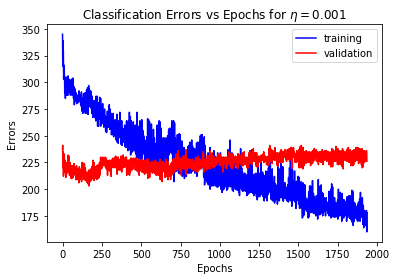

In [13]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

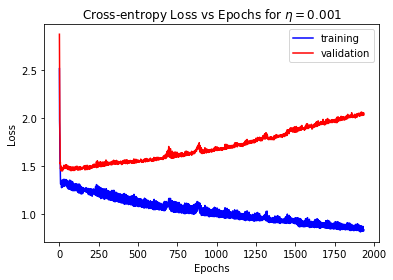

In [14]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Attempt 2: One layer, 1000 units, $\eta=0.001$, $\lambda=0.003$ 

In [15]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 1000)
hidden_layer_out = tf.nn.relu(hidden_layer_in)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [22]:
eta=1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
#accuracy = tf.reduce_mean(tf.cast(tf.equal(y_class_predicted, y_class_target), tf.float32))
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

batch_size=512

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    for step in range(1, 2001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap')})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
        
        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap')})
        i += batch_size
        
        if (step % 100 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap')})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget})
            print("Iter: %4d, xentropy-train: %4.6f, xentropy-valid: %4.6f, Train errs: %d, Valid errs: %d"%
                  (step, train_loss, valid_loss, train_error, valid_error))

Iter:  100, xentropy-train: 1.356196, xentropy-valid: 1.455486, Train errs: 313, Valid errs: 216
Iter:  200, xentropy-train: 1.318674, xentropy-valid: 1.468597, Train errs: 299, Valid errs: 222
Iter:  300, xentropy-train: 1.250689, xentropy-valid: 1.457970, Train errs: 277, Valid errs: 214
Iter:  400, xentropy-train: 1.289642, xentropy-valid: 1.490644, Train errs: 286, Valid errs: 220
Iter:  500, xentropy-train: 1.311051, xentropy-valid: 1.502795, Train errs: 306, Valid errs: 227
Iter:  600, xentropy-train: 1.248691, xentropy-valid: 1.465270, Train errs: 282, Valid errs: 218
Iter:  700, xentropy-train: 1.284227, xentropy-valid: 1.508247, Train errs: 285, Valid errs: 222
Iter:  800, xentropy-train: 1.348665, xentropy-valid: 1.518561, Train errs: 290, Valid errs: 223
Iter:  900, xentropy-train: 1.341548, xentropy-valid: 1.505363, Train errs: 303, Valid errs: 219
Iter: 1000, xentropy-train: 1.243405, xentropy-valid: 1.455942, Train errs: 269, Valid errs: 209
Iter: 1100, xentropy-train: 1.

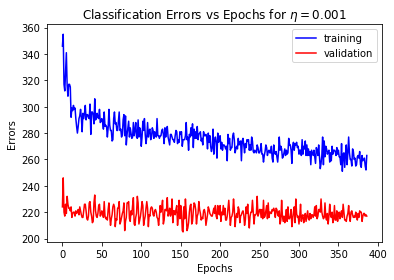

In [23]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

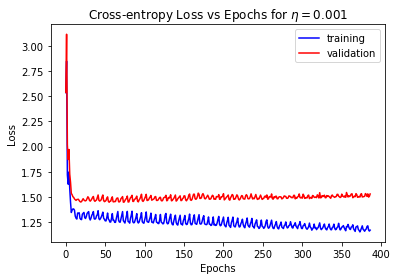

In [24]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Attempt 3: One layer, 1000 units, $\eta=0.001$, $\lambda=0.0003$, dropout rate $p=0.5$

In [33]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 1000)
keep_prob = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer_out = tf.nn.dropout(tf.nn.relu(hidden_layer_in), keep_prob)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [34]:
eta=1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

batch_size=512

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    for step in range(1, 2001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob: 1.0})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
        
        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                              keep_prob: 0.5})
        i += batch_size
        
        if (step % 100 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob: 1.0})
            print("Iter: %4d, xentropy-train: %4.5f, xentropy-valid: %4.5f, Train errs: %d, Valid errs: %d"%
                  (step, train_loss, valid_loss, train_error, valid_error))

Iter:  100, xentropy-train: 1.46870, xentropy-valid: 1.55956, Train errs: 302, Valid errs: 227
Iter:  200, xentropy-train: 1.33139, xentropy-valid: 1.46363, Train errs: 303, Valid errs: 221
Iter:  300, xentropy-train: 1.26723, xentropy-valid: 1.44354, Train errs: 293, Valid errs: 216
Iter:  400, xentropy-train: 1.27356, xentropy-valid: 1.44758, Train errs: 285, Valid errs: 218
Iter:  500, xentropy-train: 1.30846, xentropy-valid: 1.44375, Train errs: 295, Valid errs: 212
Iter:  600, xentropy-train: 1.27171, xentropy-valid: 1.44355, Train errs: 292, Valid errs: 213
Iter:  700, xentropy-train: 1.27879, xentropy-valid: 1.43616, Train errs: 276, Valid errs: 214
Iter:  800, xentropy-train: 1.31447, xentropy-valid: 1.43236, Train errs: 292, Valid errs: 214
Iter:  900, xentropy-train: 1.32589, xentropy-valid: 1.44145, Train errs: 302, Valid errs: 216
Iter: 1000, xentropy-train: 1.26453, xentropy-valid: 1.44002, Train errs: 282, Valid errs: 218
Iter: 1100, xentropy-train: 1.29640, xentropy-vali

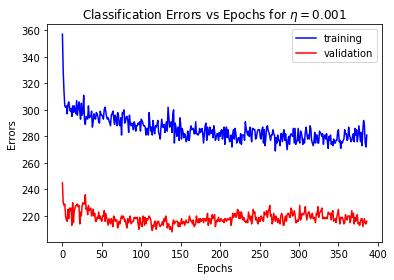

In [35]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

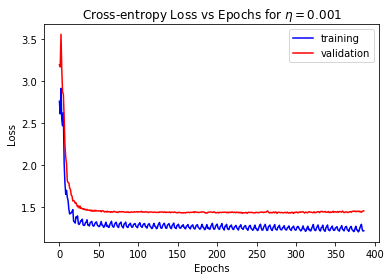

In [36]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Attempt 4: Two layers, 500 units each, $\eta=0.001$, $\lambda=0.0003$, dropout rate $p=0.5$

In [45]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer1_in, W_layer1 = build_layer(X, 500)
keep_prob1 = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer1_out = tf.nn.dropout(tf.nn.relu(hidden_layer1_in), keep_prob1)

# first hidden layer to second hidden layer
hidden_layer2_in, W_layer2 = build_layer(hidden_layer1_out, 500)
keep_prob2 = tf.placeholder(tf.float32)
hidden_layer2_out = tf.nn.dropout(tf.nn.relu(hidden_layer2_in), keep_prob2)

# second hidden layer to output
y_predicted, W_layer3 = build_layer(hidden_layer2_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2) + tf.nn.l2_loss(W_layer3)
cross_entropy += penalty * regularizers

In [46]:
eta=1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

batch_size=512

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    for step in range(1, 2001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
        
        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                              keep_prob1: 0.5,
                                                              keep_prob2: 0.5})
        i += batch_size
        
        if (step % 100 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0})
            print("Iter: %4d, xentropy-train: %4.5f, xentropy-valid: %4.5f, Train errs: %d, Valid errs: %d"%
                  (step, train_loss, valid_loss, train_error, valid_error))

Iter:  100, xentropy-train: 1.51356, xentropy-valid: 1.56150, Train errs: 317, Valid errs: 228
Iter:  200, xentropy-train: 1.43123, xentropy-valid: 1.50494, Train errs: 309, Valid errs: 223
Iter:  300, xentropy-train: 1.39483, xentropy-valid: 1.50054, Train errs: 305, Valid errs: 226
Iter:  400, xentropy-train: 1.38197, xentropy-valid: 1.49315, Train errs: 296, Valid errs: 229
Iter:  500, xentropy-train: 1.40593, xentropy-valid: 1.49015, Train errs: 302, Valid errs: 220
Iter:  600, xentropy-train: 1.37973, xentropy-valid: 1.48309, Train errs: 309, Valid errs: 222
Iter:  700, xentropy-train: 1.38197, xentropy-valid: 1.48393, Train errs: 300, Valid errs: 222
Iter:  800, xentropy-train: 1.40503, xentropy-valid: 1.47829, Train errs: 308, Valid errs: 221
Iter:  900, xentropy-train: 1.41595, xentropy-valid: 1.47659, Train errs: 327, Valid errs: 223
Iter: 1000, xentropy-train: 1.37073, xentropy-valid: 1.47582, Train errs: 304, Valid errs: 219
Iter: 1100, xentropy-train: 1.39242, xentropy-vali

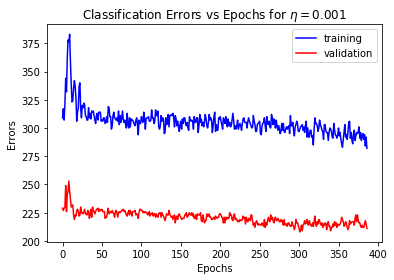

In [47]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

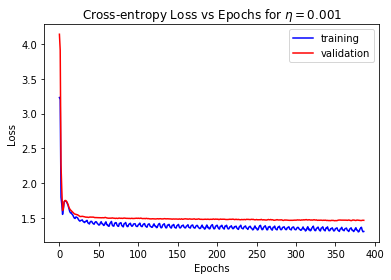

In [48]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Noticing that two layers showing validation loss decreasing very slowly, but decreasing nonetheless, over many epochs.

Attempt 5: Three layers, 500 units each, $\eta=0.001$, $\lambda=0.001$, dropout rate $p=0.5$

In [57]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer1_in, W_layer1 = build_layer(X, 500)
keep_prob1 = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer1_out = tf.nn.dropout(tf.nn.relu(hidden_layer1_in), keep_prob1)

# first hidden layer to second hidden layer
hidden_layer2_in, W_layer2 = build_layer(hidden_layer1_out, 250)
keep_prob2 = tf.placeholder(tf.float32)
hidden_layer2_out = tf.nn.dropout(tf.nn.relu(hidden_layer2_in), keep_prob2)

# second hidden layer to third hidden layer
hidden_layer3_in, W_layer3 = build_layer(hidden_layer2_out, 100)
keep_prob3 = tf.placeholder(tf.float32)
hidden_layer3_out = tf.nn.dropout(tf.nn.relu(hidden_layer3_in), keep_prob3)

# second hidden layer to output
y_predicted, W_layer4 = build_layer(hidden_layer3_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 1e-3
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2) + tf.nn.l2_loss(W_layer3) + tf.nn.l2_loss(W_layer4)
cross_entropy += penalty * regularizers

In [58]:
eta=5e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

batch_size=512

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    for step in range(1, 2001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0,
                                                           keep_prob3: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0,
                                                           keep_prob3: 1.0})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
        
        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                              keep_prob1: 0.5,
                                                              keep_prob2: 0.5,
                                                              keep_prob3: 0.5})
        i += batch_size
        
        if (step % 100 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0,
                                                           keep_prob3: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob1: 1.0,
                                                           keep_prob2: 1.0,
                                                           keep_prob3: 1.0})
            print("Iter: %4d, xentropy-train: %4.5f, xentropy-valid: %4.5f, Train errs: %d, Valid errs: %d"%
                  (step, train_loss, valid_loss, train_error, valid_error))

Iter:  100, xentropy-train: 1.60448, xentropy-valid: 1.67106, Train errs: 318, Valid errs: 222
Iter:  200, xentropy-train: 1.55099, xentropy-valid: 1.61962, Train errs: 320, Valid errs: 224
Iter:  300, xentropy-train: 1.47526, xentropy-valid: 1.59019, Train errs: 313, Valid errs: 222
Iter:  400, xentropy-train: 1.45533, xentropy-valid: 1.56511, Train errs: 298, Valid errs: 226
Iter:  500, xentropy-train: 1.46466, xentropy-valid: 1.55073, Train errs: 309, Valid errs: 223
Iter:  600, xentropy-train: 1.43232, xentropy-valid: 1.52988, Train errs: 313, Valid errs: 225
Iter:  700, xentropy-train: 1.41327, xentropy-valid: 1.51212, Train errs: 299, Valid errs: 221
Iter:  800, xentropy-train: 1.42741, xentropy-valid: 1.50645, Train errs: 298, Valid errs: 218
Iter:  900, xentropy-train: 1.43986, xentropy-valid: 1.48974, Train errs: 326, Valid errs: 220
Iter: 1000, xentropy-train: 1.38712, xentropy-valid: 1.48850, Train errs: 302, Valid errs: 222
Iter: 1100, xentropy-train: 1.40433, xentropy-vali

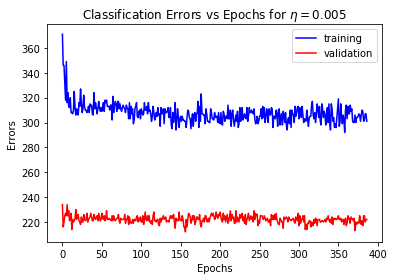

In [59]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

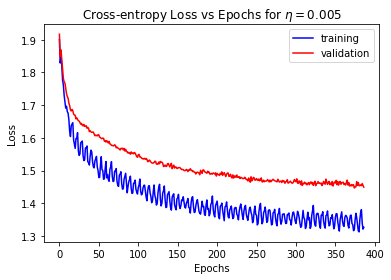

In [60]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Three layers doesn't seem to do any better.

In [89]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer1_in, W_layer1 = build_layer(X, 200)
keep_prob1 = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer1_out = tf.nn.dropout(tf.nn.relu(hidden_layer1_in), keep_prob1)

# second hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer1_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 1e-5
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [90]:
eta=1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

batch_size=512

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    for step in range(1, 20001):
        if i >= trainData.shape[0]:
            i -= trainData.shape[0]
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob1: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob1: 1.0})
            train_xentropy_losses.append(train_loss)
            train_errors.append(train_error)
            valid_xentropy_losses.append(valid_loss)
            valid_errors.append(valid_error)
        
        indices = range(i, i+batch_size)
        _, loss = sess.run([train, cross_entropy], feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                              y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                              keep_prob1: 0.5})
        i += batch_size
        
        if (step % 1000 == 0):
            train_error, train_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: trainData.take(indices, axis=0, mode='wrap'),
                                                           y_target: trainTarget.take(indices, axis=0, mode='wrap'),
                                                           keep_prob1: 1.0})
            valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                feed_dict={X: validData, y_target: validTarget,
                                                           keep_prob1: 1.0})
            print("Iter: %4d, xentropy-train: %4.5f, xentropy-valid: %4.5f, Train errs: %d, Valid errs: %d"%
                  (step, train_loss, valid_loss, train_error, valid_error))

Iter: 1000, xentropy-train: 1.30908, xentropy-valid: 1.43549, Train errs: 298, Valid errs: 220
Iter: 2000, xentropy-train: 1.32999, xentropy-valid: 1.44004, Train errs: 303, Valid errs: 221
Iter: 3000, xentropy-train: 1.30431, xentropy-valid: 1.43249, Train errs: 286, Valid errs: 216
Iter: 4000, xentropy-train: 1.29617, xentropy-valid: 1.44247, Train errs: 283, Valid errs: 216
Iter: 5000, xentropy-train: 1.26395, xentropy-valid: 1.44947, Train errs: 289, Valid errs: 212
Iter: 6000, xentropy-train: 1.27415, xentropy-valid: 1.47205, Train errs: 286, Valid errs: 217
Iter: 7000, xentropy-train: 1.23647, xentropy-valid: 1.48819, Train errs: 270, Valid errs: 218
Iter: 8000, xentropy-train: 1.21290, xentropy-valid: 1.49962, Train errs: 272, Valid errs: 219
Iter: 9000, xentropy-train: 1.22709, xentropy-valid: 1.53652, Train errs: 275, Valid errs: 217
Iter: 10000, xentropy-train: 1.22531, xentropy-valid: 1.56677, Train errs: 268, Valid errs: 216
Iter: 11000, xentropy-train: 1.18071, xentropy-va

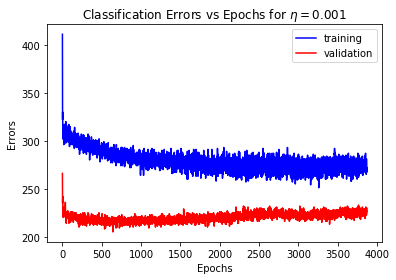

In [91]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

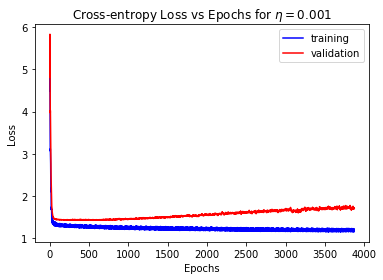

In [92]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs for '+r'$\eta=$'+str(eta))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()